# S4E8 Kaggle Playground Series Comp - Predict Poisonous Mushrooms
* Classify if a mushroom is poisonous or not based on physical features.
* This mostly is a synthetic dataset.
* Binary Classification Problem:
    * Class 0: Edible (e)
    * Class 1: Poisonous (p)
* Metric is Matthews correlation coefficient (MCC)
    * https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
    

## Config

In [1]:
class Config():
    seed = 12
    folds = 5
    
config = Config()

## Imports

In [2]:
import statistics
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

!pip install scienceplots
import scienceplots
plt.style.use(['science','no-latex'])

## Read Data, Top Level Info

In [3]:
root_dir = '/kaggle/input/playground-series-s4e8'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

In [4]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (3116945, 22)


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


Test Data Shape: (2077964, 21)


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,10.75,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,3.14,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,8.51,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,13.70,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


Sample Submission Shape: (2077964, 2)


,id,class
0,3116945,e
1,3116946,e
2,3116947,e
3,3116948,e
4,3116949,e


In [5]:
def df_info(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

df_info(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
id,int64,0,0.000000,3116945,3116945
class,object,0,0.000000,2,3116945
cap-diameter,float64,4,0.000001,3913,3116941
cap-shape,object,40,0.000013,74,3116905
cap-surface,object,671023,0.215282,83,2445922
cap-color,object,12,0.000004,78,3116933
does-bruise-or-bleed,object,8,0.000003,26,3116937
gill-attachment,object,523936,0.168093,78,2593009
gill-spacing,object,1258435,0.403740,48,1858510
gill-color,object,57,0.000018,63,3116888


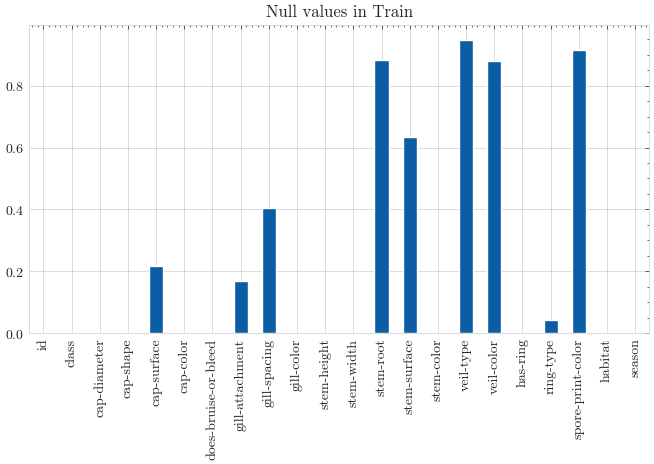

In [6]:
fig,ax = plt.subplots(figsize=(8,4))
(train.isnull().mean()).abs().plot.bar(ax=ax)
plt.title("Null values in Train");

### Top Level Takeways
* Pretty big - will be slow especially with random forest,
    * Train: 3+ Million rows, Test: 2+ million rows
    * consider subsample 
* Significant missing data.  Try several approaches
    * Drop rows > threshold (~20%) and impute the rest
    * Mean value
    * sklearn simple imputers, robust
    * Iterative
    * Smart (LGBM, XGB based) imputers - train a separate model to fill in the gaps
    * Try a new library - maybe autoimpute
* 3 features are floats, the rest objects
    * Stem height, stem width, cap diameter
* Categorical columns are pretty high cardinality (20-80)
    * One hot encoding will be huge.

## Floating Point Feature Distributions

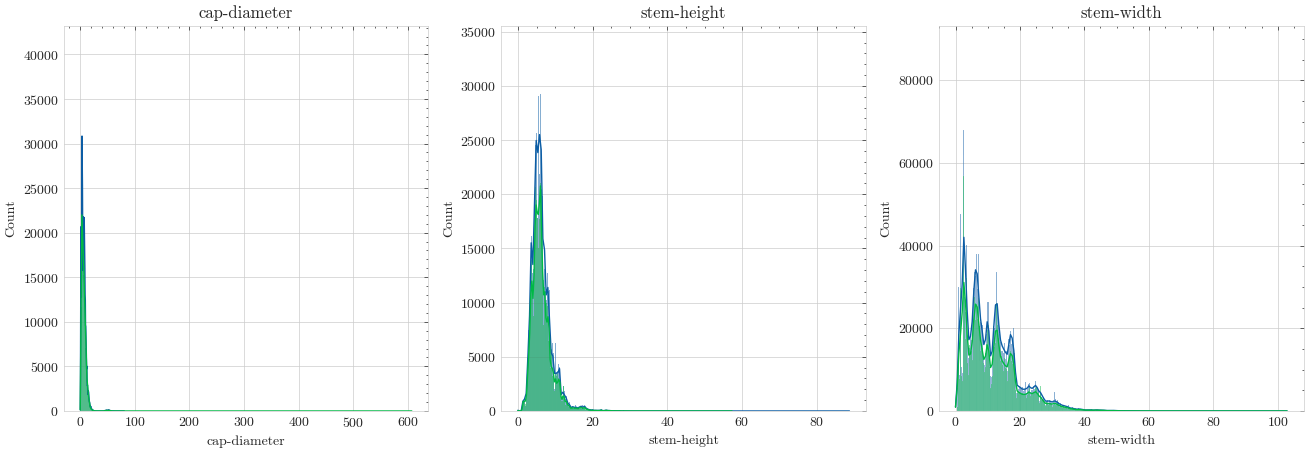

In [7]:
float_features = [col for col in train.columns if train[col].dtype=='float']
rows = int(np.ceil(len(float_features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(float_features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)


## Target Distribution
* Pretty even, see below

In [8]:
train['class'].value_counts()   #.plot(kind='hist')

class
p    1705396
e    1411549
Name: count, dtype: int64

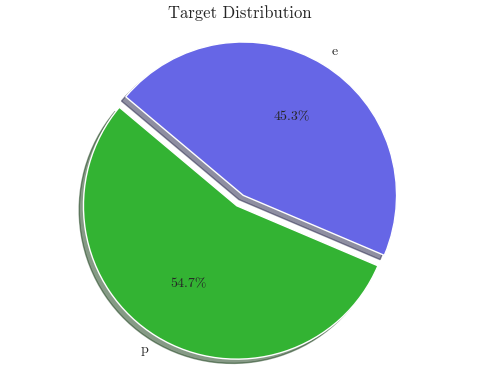

In [9]:
def plot_pie_chart(data, target, title, ax):
    data_counts = data[target].value_counts()
    labels = data_counts.index
    sizes = data_counts.values
    colors = [(0.2, 0.7, 0.2), (0.4,0.4,0.9)]
    explode = [0.04] * len(labels)  # Create an explode list with the same length as the number of labels

    ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal') 
    ax.set_title(title)

fig, ax = plt.subplots(figsize=(5, 4))  # Create a single subplot with specified size

plot_pie_chart(train, "class", "Target Distribution", ax)

plt.tight_layout()
plt.show()

## Feature Distrubutions


In [10]:
obj_cols = [col for col in train.columns if train[col].dtype == 'object']
obj_cols

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

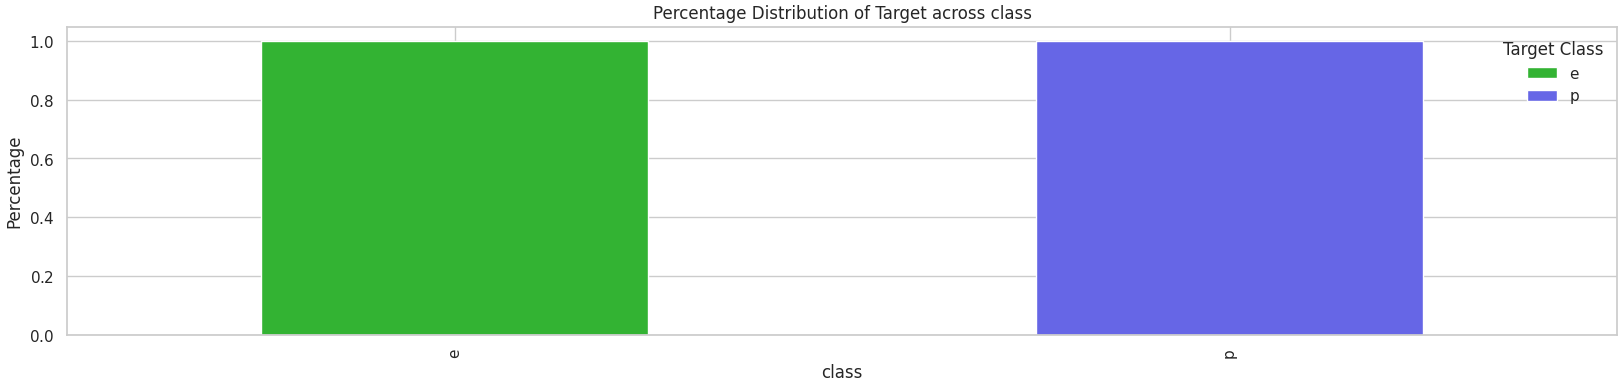

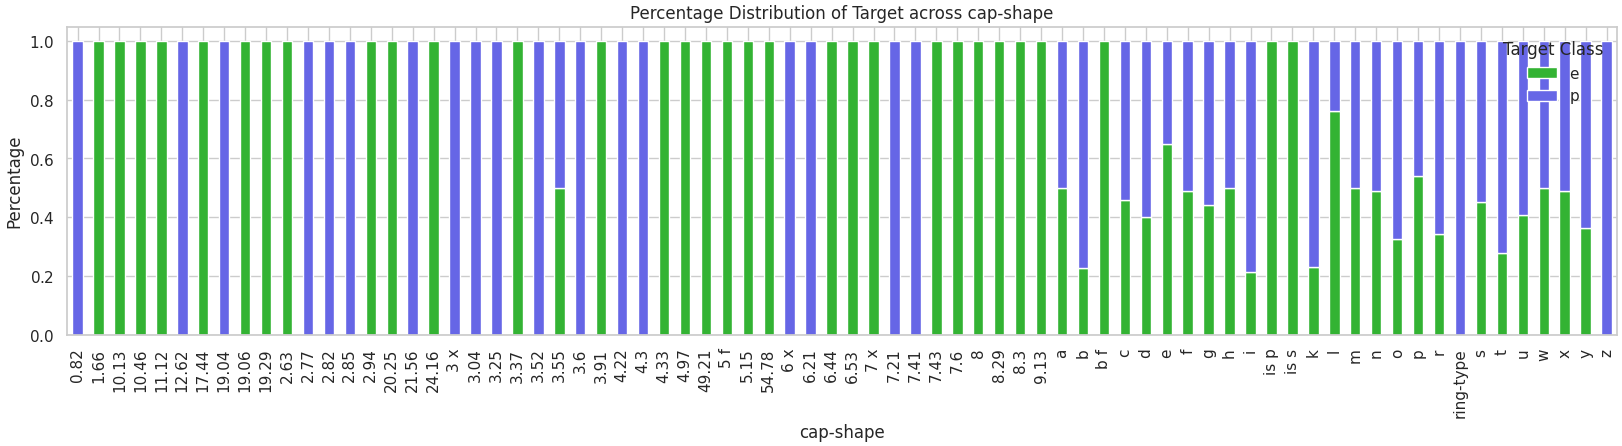

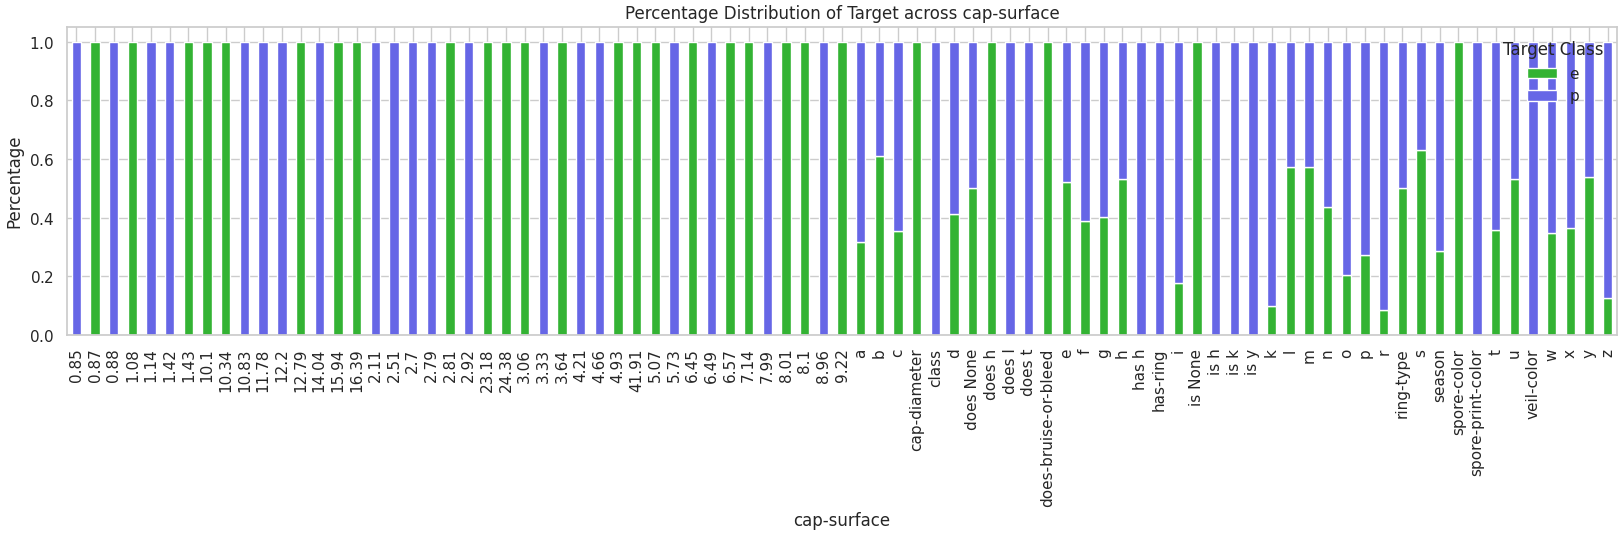

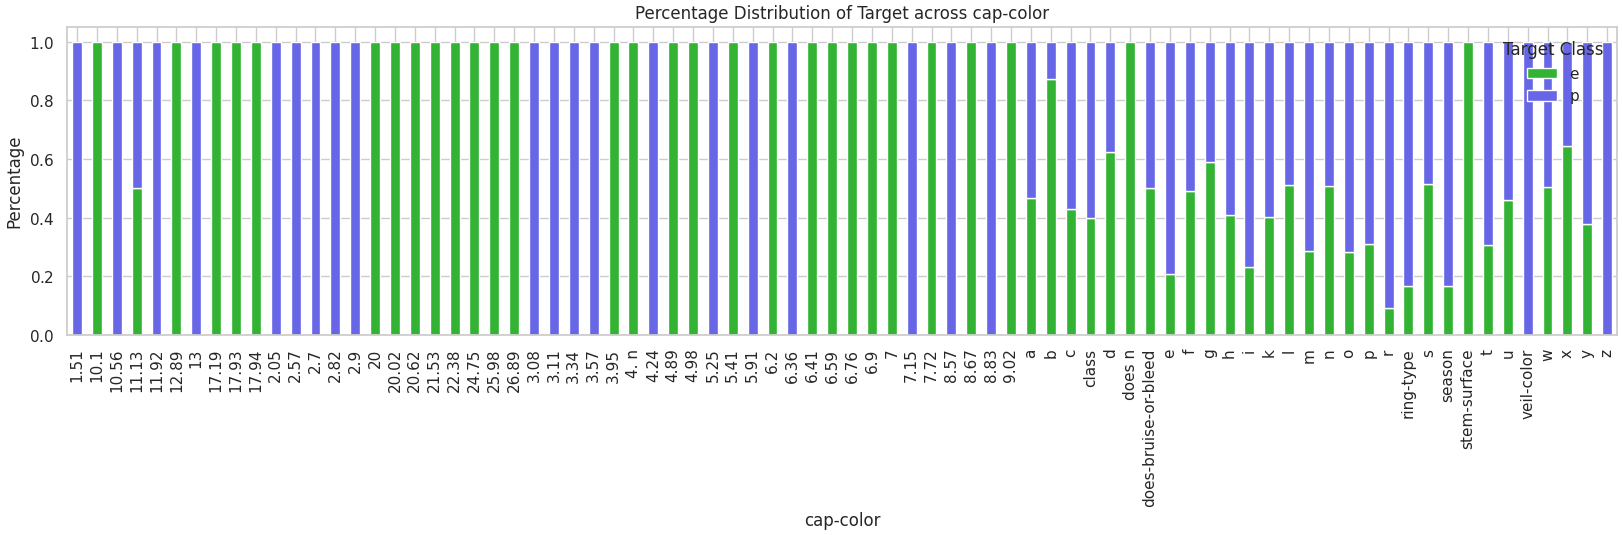

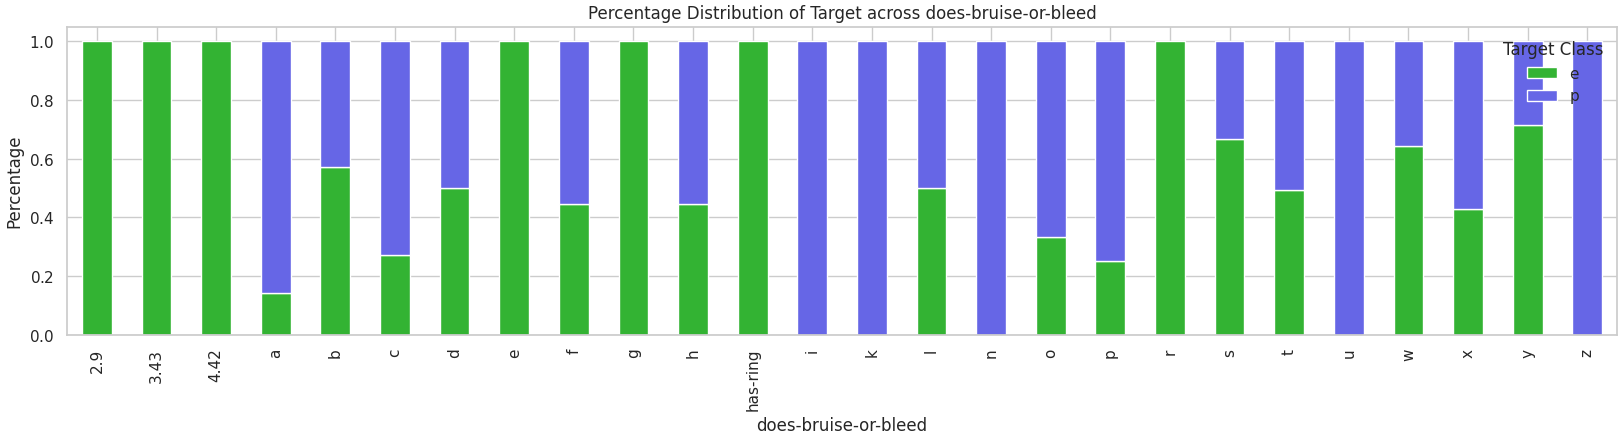

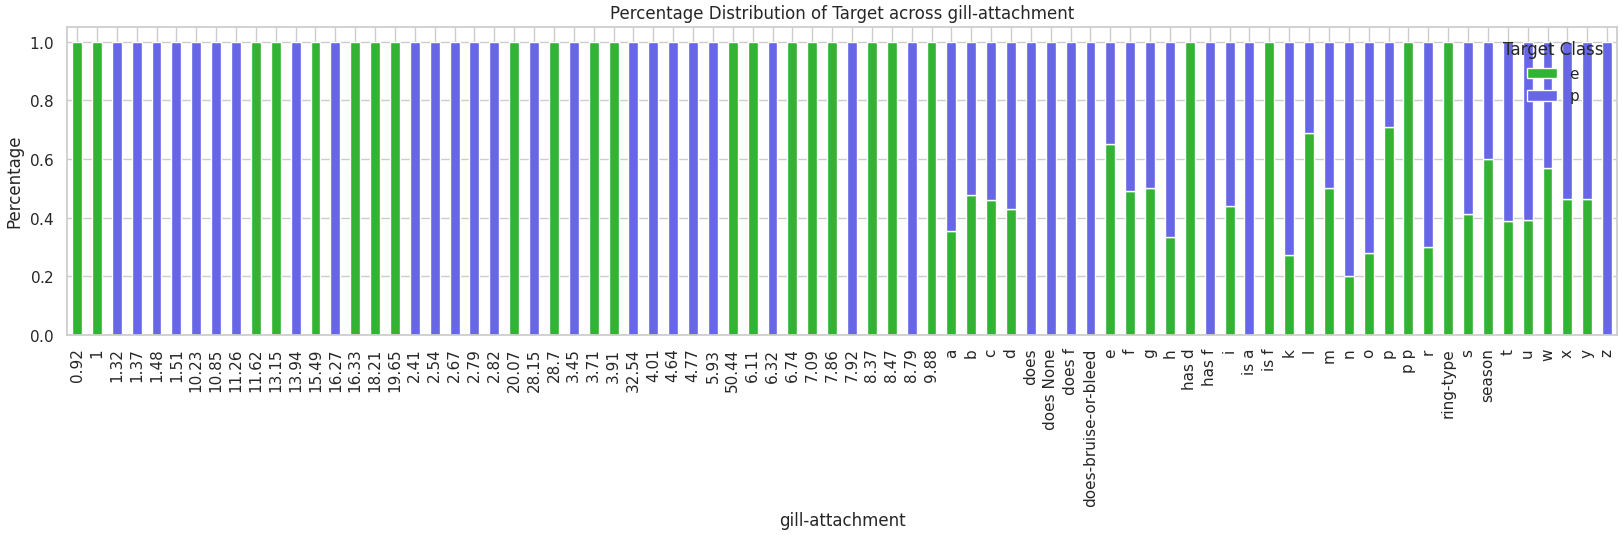

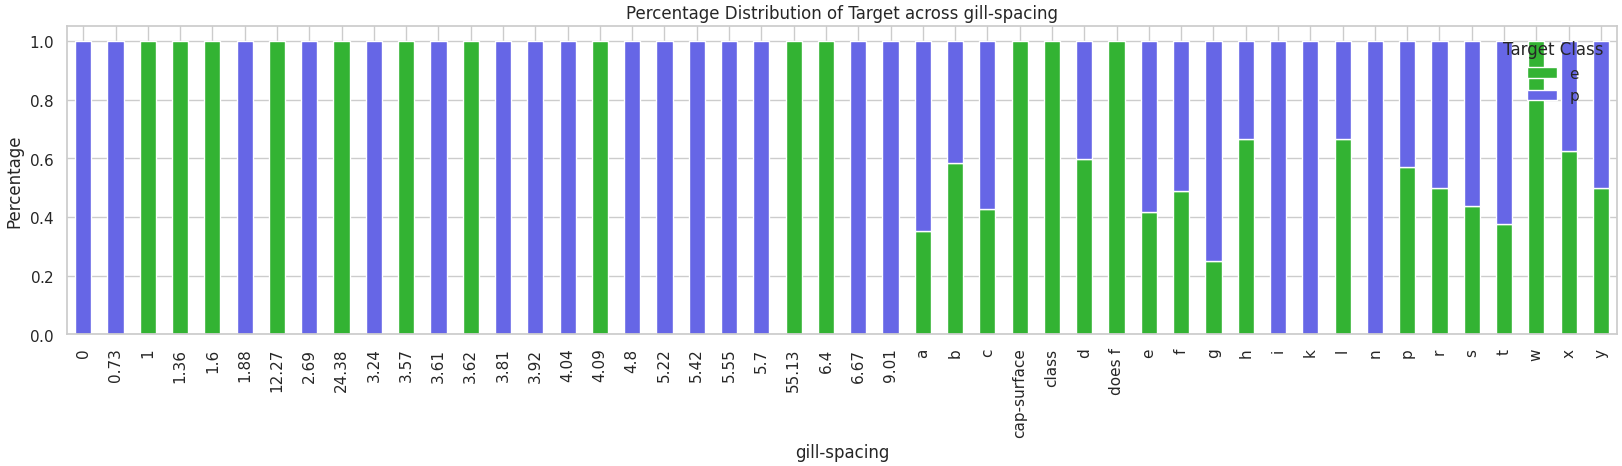

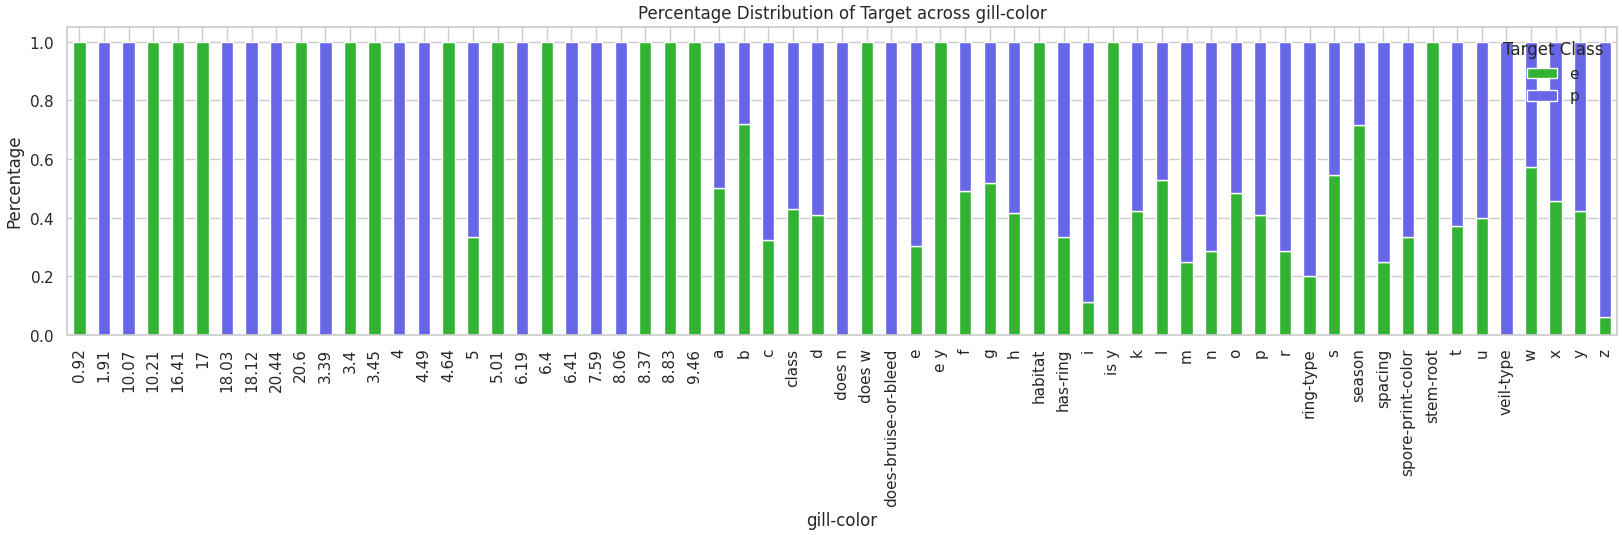

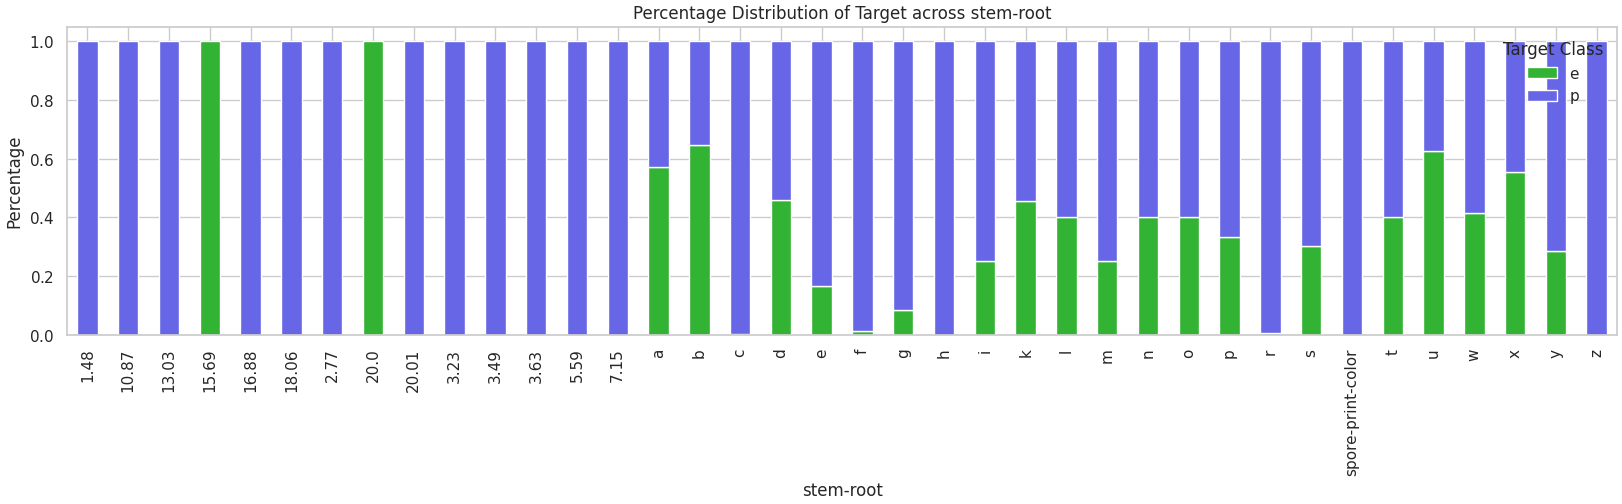

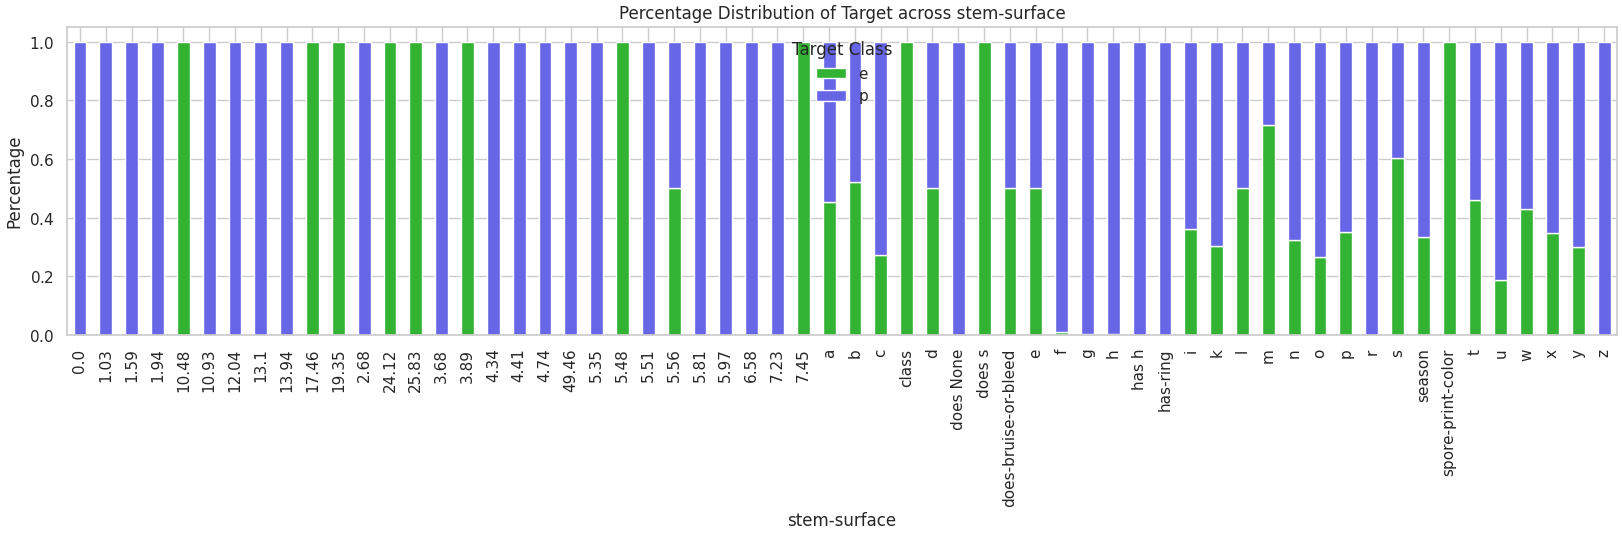

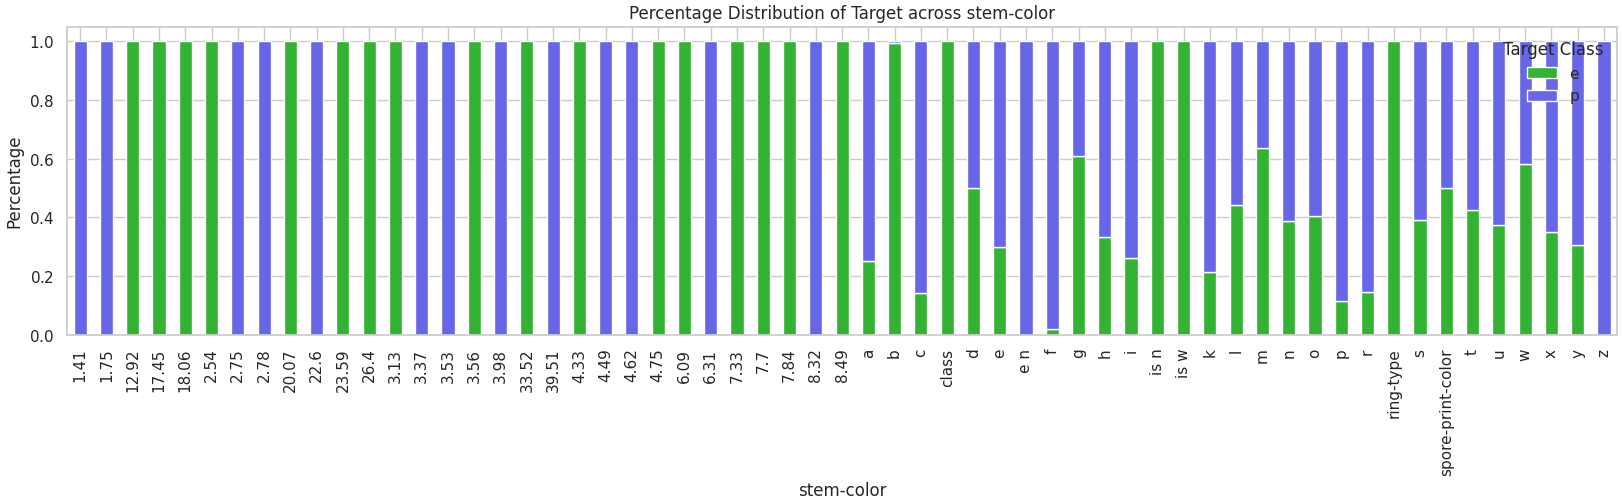

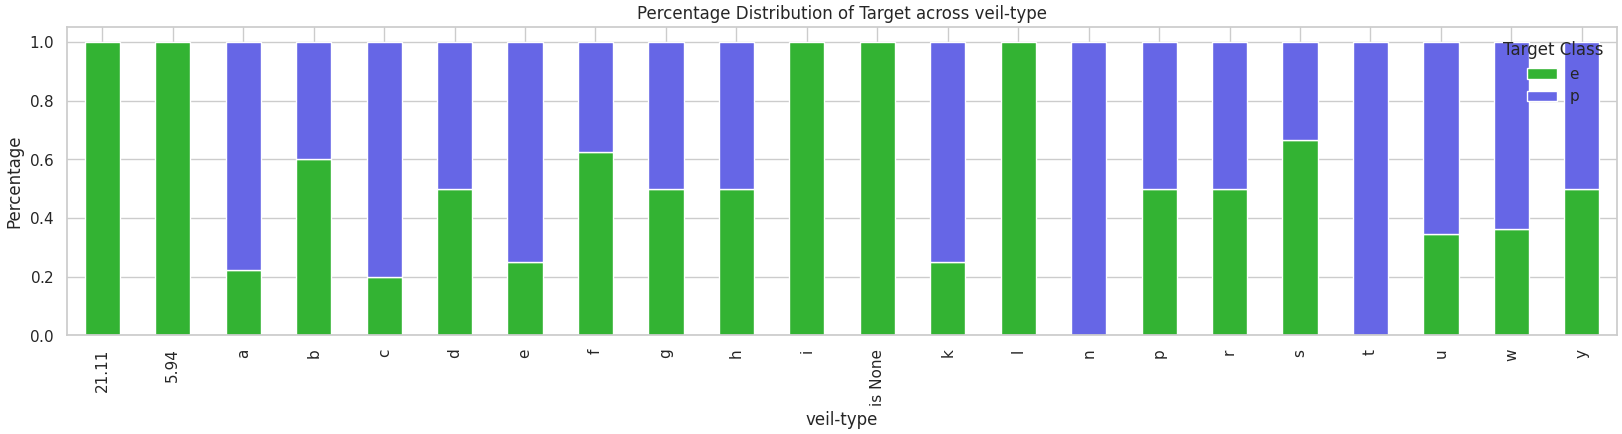

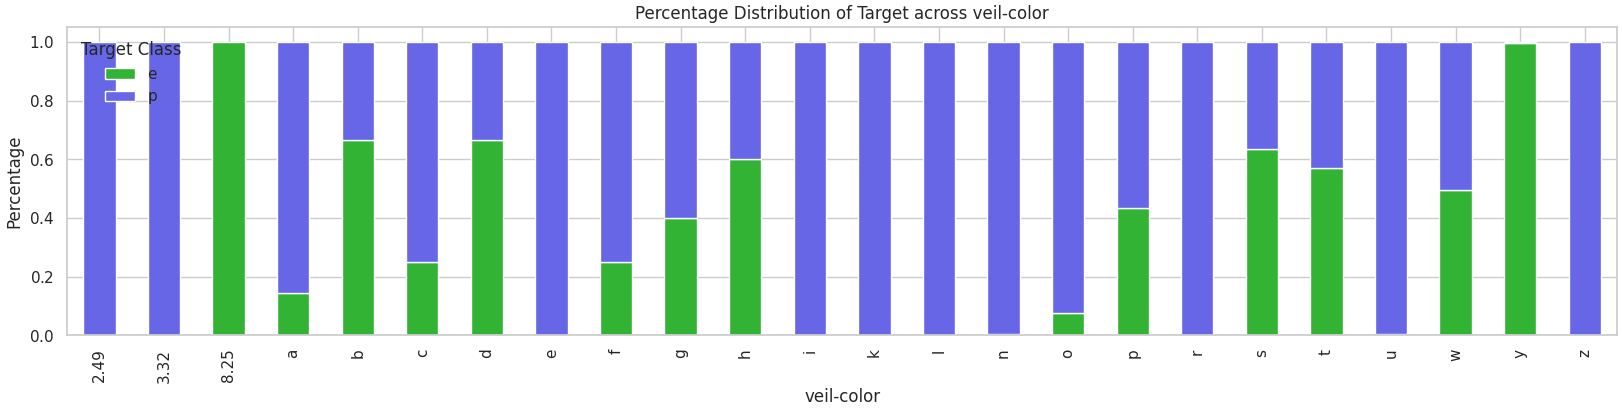

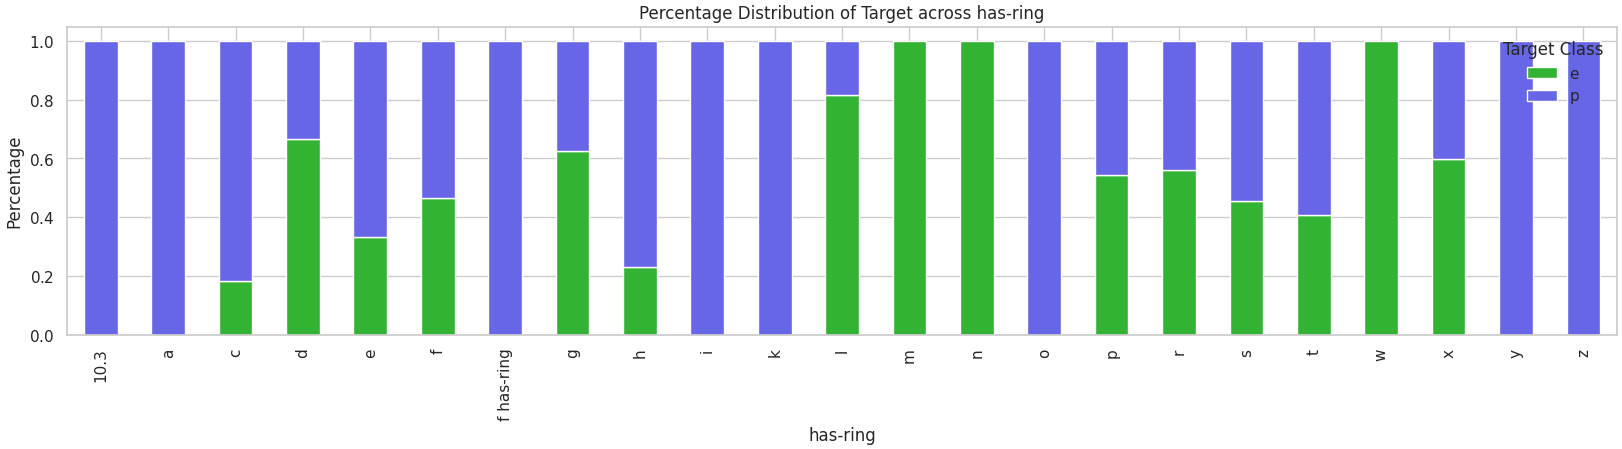

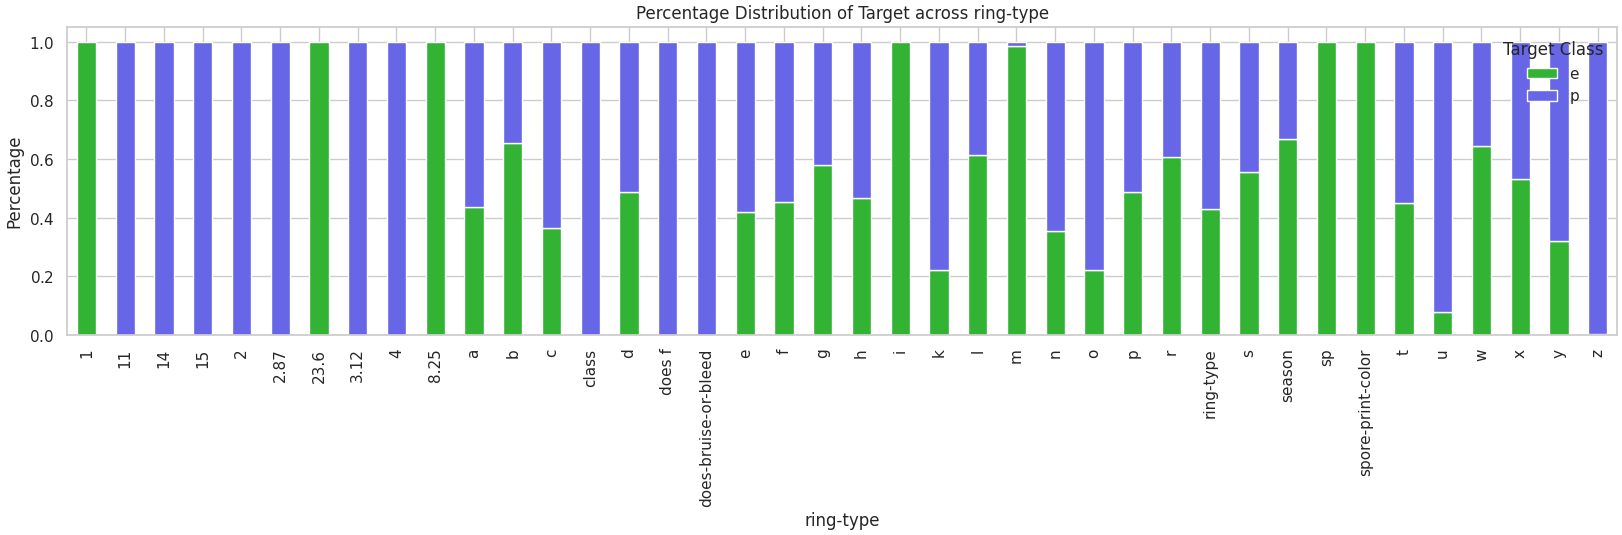

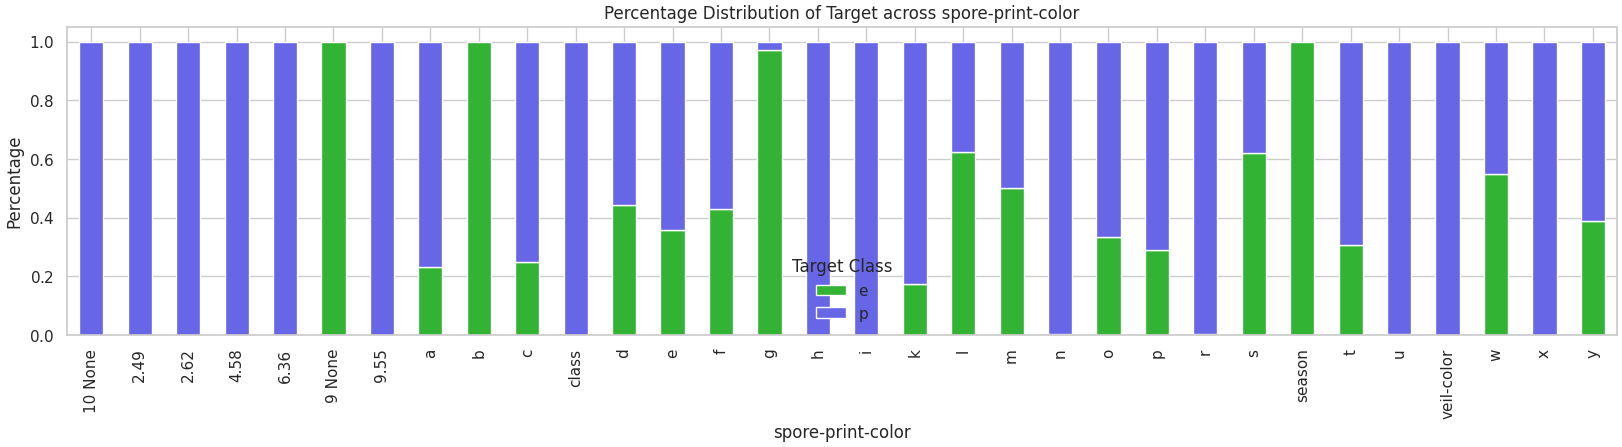

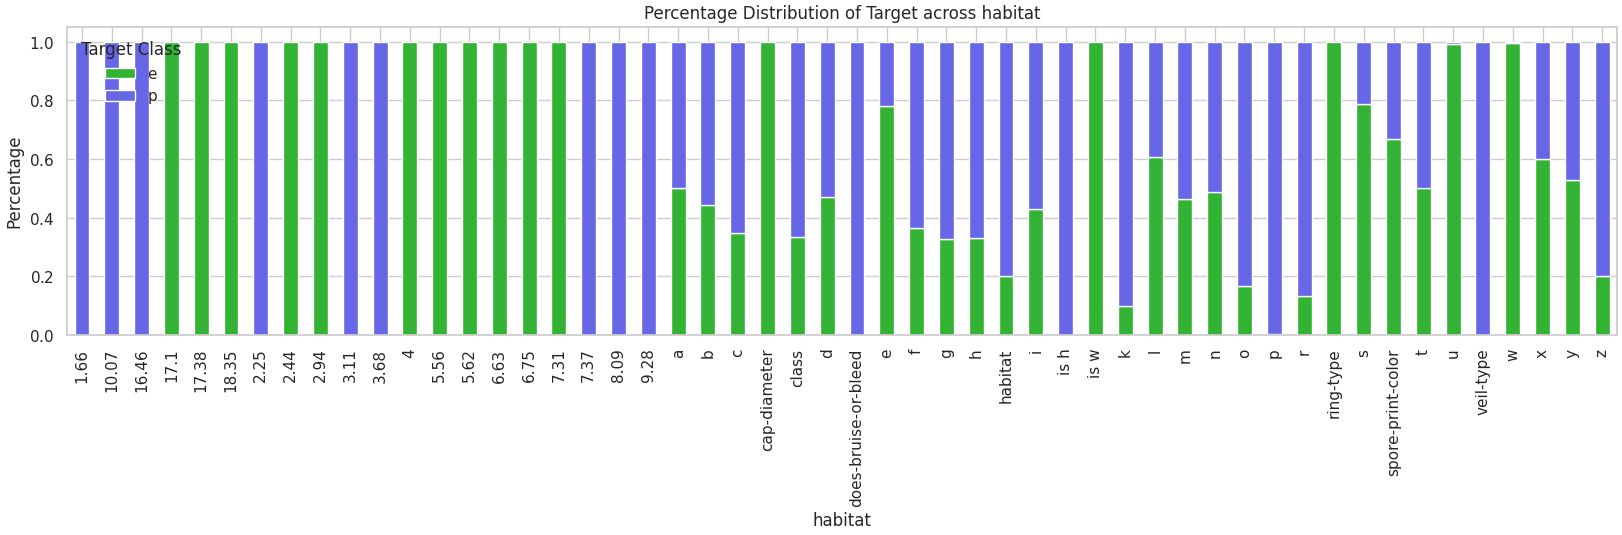

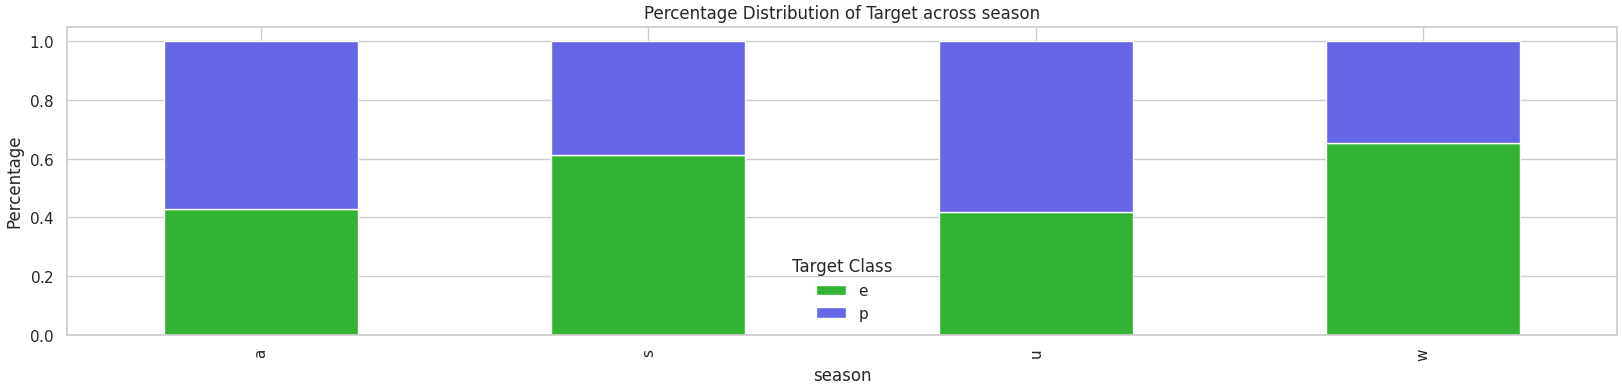

In [11]:
# Crosstab from @arunklenin, and above, I like the look of his plots, but maybe tweak colors more
cat_cols = [col for col in obj_cols if train[col].nunique() <100 ]
colors = [(0.2, 0.7, 0.2), (0.4,0.4,0.9)]
for col in cat_cols:
    contingency_table = pd.crosstab(train[col], train['class'], normalize='index')
    sns.set(style="whitegrid")
    contingency_table.plot(kind="bar", stacked=True, color=colors,figsize=(20, 4))
    plt.title(f"Percentage Distribution of Target across {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.legend(title="Target Class")
    plt.show()



# Preprocessing - Nan Strategy
* remove all rows with nan's
    * too many to do this, first drop columns > 20%
* First test - train on floats features only

In [12]:
# # drop nans and inf

# def drop_nans_inf(df):
#     df = df.replace([np.inf, -np.inf], np.nan)  # Replace inf values with NaN
#     df = df.dropna(axis=0, how='any')
    
#     return df

# print(f'length of train: {len(train)}')
# train = drop_nans_inf(train)
# print(f'length of train: {len(train)}')

In [13]:
# make a feature to count the number of nans' in a row
train['nan_count'] = train.isnull().sum(axis=1)
test['nan_count'] = test.isnull().sum(axis=1)
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,nan_count
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a,5
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w,4
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w,4
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u,6
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a,6


In [14]:
# look at distribution of nan count
train.nan_count.value_counts()   #.plot(kind='hist')

nan_count
5    1253551
6     786657
4     615895
7     243195
3     153087
2      43419
8      21078
1         53
9         10
Name: count, dtype: int64

In [15]:
# git rid of rows with high nan count
# Assuming 'num_nans' is the feature containing the count of NaN values

#train = train[train['nan_count'] != 9]  # prob a way to or these.
#train = train[train['nan_count'] != 8]
#train = train[train['nan_count'] != 7]
# train = train[train['nan_count'] != 6]
# train = train[train['nan_count'] != 5]
# train = train[train['nan_count'] != 4]
# train = train[train['nan_count'] != 3]

train.shape

(3116945, 23)

In [16]:
# with 5-9 removed, down to 800K, what is the target distribution?
train['class'].value_counts()

# so it actually looks like their might be some signal in the number of nans, and the edibles or more likely to have a high number of nans.
# could do a study here and plot.

class
p    1705396
e    1411549
Name: count, dtype: int64

In [17]:
# convert class to 0 and 1
train['class'] = train['class'].map({'e':0,'p':1})
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,nan_count
0,0,0,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a,5
1,1,1,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w,4
2,2,0,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w,4
3,3,0,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u,6
4,4,0,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a,6


## Select Features

In [18]:
features = [col for col in test.columns]
features.remove('id')
features.remove('nan_count')
features

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

## Impute remaining data
* Start with mode

In [19]:
for col in features:
    train[col].fillna(train[col].value_counts().index[0],inplace=True) 
    test[col].fillna(train[col].value_counts().index[0], inplace=True) # so no data leakage 
    

## Select Features

In [20]:
features = [f for f in features if train[f].dtype == 'float']
features.append('nan_count')
for col in obj_cols:
    features.append(col)
features.remove('class')
obj_cols.remove('class')
features

['cap-diameter',
 'stem-height',
 'stem-width',
 'nan_count',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

## Split data
* start with test/train split, then go to CV

In [21]:
from sklearn.model_selection import train_test_split 

y = train['class'] 
x_train, x_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2, random_state=12) 
x_test = test[features]


In [22]:
train['class']

0          0
1          1
2          0
3          0
4          0
          ..
3116940    0
3116941    0
3116942    1
3116943    0
3116944    1
Name: class, Length: 3116945, dtype: int64

### Cross Validation Function

In [23]:
from sklearn.model_selection import StratifiedKFold
folds = 5

# if continuous, change predict_proba to predict
def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=folds,random_state = seed,shuffle=True)
    # Use KFold if target is continuous
    #skf = KFold(n_splits=folds,random_state = seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict(x_valid)
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = matthews_corrcoef(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
          print(f'Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict(test[features])
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = matthews_corrcoef(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'MCC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

## Models
* Start with decistion tree

In [24]:
from sklearn.metrics import accuracy_score, matthews_corrcoef

## Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

# model_dt = DecisionTreeClassifier( max_depth=4, random_state=42)
# model_dt.fit(x_train, y_train)
# # pred_dt = model_dt.predict(x_valid) 
# # dt_score = accuracy_score(pred_dt,y_valid)
# # print(f'Decision Tree Accuracy Score: {dt_score}')

# preds_dt,scores_dt,oof_score_dt,oof_dt = run_cv_and_predict(train,test,features,model_dt,12,verbose=True)

# # get the mode of the prediction data
# preds_mode = []
# for i in range(len(preds_dt)):
#     preds_mode.append(statistics.mode(preds_dt[i]))

#preds_mode[0:10]

# first run: Decision Tree Accuracy Score: 0.7889852361053843
# add nan count: Decision Tree Accuracy Score: 0.7972626176218991
# add another removal of rows with highter nan counts. Removing rows with 4 nan counts as well:
# Decision Tree Accuracy Score: 0.8588726088726089
# keep 5 nan count as well: Decision Tree Accuracy Score: 0.63577
# 5 fold .79752


## Catboost
* Good gradient boosted tree based and good with categorical

In [26]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(verbose=False,cat_features=obj_cols,task_type='GPU')
# model_cat.fit(X_train,y_train)
# preds_cat = model_cat.predict_proba(X_valid)[:,1]
# score_cat = roc_auc_score(y_valid,preds_cat)
# print(f'Catboost score: {score_cat}')

preds_cat,scores_cat,oof_score_cat,oof_cat = run_cv_and_predict(train,test,features,model_cat,config.seed,verbose=True)

# first run with 5 and > nan_counts removed, Accuracy score: 0.99374, MCC score was like .98xxx
# not removing 5 nan count: MCC score: 0.98240, Stdev: 0.00042, OOF score: 0.98240
# removing 4 nan)count: 

# keep nan count of 8, cv = .98099
# keep nan count of 9, cv = .98087

Score, fold 1: 0.9809694933950067
Score, fold 2: 0.9806552948486688
Score, fold 3: 0.9811922877105875
Score, fold 4: 0.9806691900478988
Score, fold 5: 0.980794980373548
MCC score: 0.98086, Stdev: 0.00020, OOF score: 0.98086


In [27]:
# get the mode of the prediction data
preds_mode = []
for i in range(len(preds_cat)):
    preds_mode.append(statistics.mode(preds_cat[i]))

## Submission

* sample submission to start

In [28]:
ss['class'] = preds_mode
ss['class'] = ss['class'].map({0:'e',1:'p'})
ss.to_csv('submission.csv',index=False)
ss.head()

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e


In [29]:
#ss.value_counts().sum()